# day 3 tutorial

Run the whole notebook by selecting "Restart & Run All" from the "Kernel" menu (above).

**TO RUN LOCALLY users need to install ipywidgets and ipyleaflet and enable the widget extension for jupyter:**
```
pip install ipywidgets
pip install ipyleaflet
jupyter nbextension enable --py widgetsnbextension
```
**notes:**
* old code that Yaxing might still want to use is at bottom


In [1]:
%matplotlib notebook
import os                            # core py3 
import json
from io import StringIO

import requests                      # data
import numpy as np
import xarray as xr
import pandas as pd
from shapely.geometry import shape

import ipywidgets as wg              # widgets and plotting
import ipyleaflet as mwg 
import matplotlib as plt
from matplotlib import cm, colors
plt.rcParams['figure.figsize'] = [9, 5]

import warnings                      # testing
warnings.filterwarnings('ignore')

url = "https://daac.ornl.gov/cgi-bin/viz/download.pl?" # SMV
auth = dict(ORNL_DAAC_USER_NUM=str(32863))             # Jack

## SMV Datasets

[*docs/smvdatasets.csv*](docs/smvdatasets.csv) is a copy of the datasets table from the [SMV User Guide](https://daac.ornl.gov/soilmoisture/guide.html). Read it into a `pandas` data frame and display it:

In [2]:
smvds = pd.read_csv("docs/smvdatasets.csv", index_col="dataset", header=0)
smvds

,source,type,units,description,soil_zone,soil_depth,native_res,time_coverage
dataset,,,,,,,,
SoilSCAPE_surface,SoilSCAPE,in situ,m3/m3,Mean vol (%) soil moisture at 0-5 cm,surface,"5, 20, 50 cm",point,2011-present
SoilSCAPE_rootzone,SoilSCAPE,in situ,m3/m3,Mean vol (%) soil moisture at 0-100 cm,rootzone,"5, 20, 50 cm",point,2011-present
AirMOSS_in-ground_surface,AirMOSS,in situ,m3/m3,Mean vol (%) soil moisture at 0-5 cm,surface,"2, 5, 10, 20, 40, 60, 80 cm",point,2012-2015
AirMOSS_in-ground_rootzone,AirMOSS,in situ,m3/m3,Mean vol (%) soil moisture at 0-100 cm,rootzone,"2, 5, 10, 20, 40, 60, 80 cm",point,2012-2015
COSMOS_surface,COSMOS,in situ,m3/m3,Mean vol (%) soil moisture at 0-5 cm,surface,0-30 cm,point,2008-present
COSMOS_rootzone,COSMOS,in situ,m3/m3,Mean vol (%) soil moisture at 0-100 cm,rootzone,0-30 cm,point,2008-present
AirMOSS_L2_3_surface,AirMOSS,airborne,m3/m3,Mean vol (%) soil moisture at 0 cm,surface,"0, 10, 30 cm",90-m,2012-2015
AirMOSS_L2_3_rootzone,AirMOSS,airborne,m3/m3,Mean vol (%) soil moisture at 0-30cm,rootzone,"0, 10, 30 cm",90-m,2012-2015
AirMOSS_L4_rootzone,AirMOSS,airborne,m3/m3,Mean vol (%) soil moisture at 0-100cm,rootzone,"0-10, 10-40, 40-100 cm",90-m,2012-2015


## Download a SMV dataset with `requests`
Example: 
https://daac.ornl.gov/cgi-bin/viz/download.pl?lt=30&ln=-100&d=smap

**The SMV data from the url above can be downloaded with the `requests` package:**
```{python}
url = "https://daac.ornl.gov/cgi-bin/viz/download.pl?"
inlat, inlon = 30, -100

r = requests.get(
    "".join([url, "lt=", str(inlat), "&ln=", str(inlon), "&d=smap"]),
    cookies=dict(ORNL_DAAC_USER_NUM="10"))
```

**The response text can be passed to `pandas.read_csv()` as a pseudo-file using `io.StringIO()`:**
```{python}
lat, lon = StringIO(r.text).readlines()[2].split("Location: ")[1].strip().split(", ")
df = pd.read_csv(StringIO(r.text), header=4, index_col="time")
```
**We read from TXT file for now because I've been abusing the SMV service with my testing:**

In [4]:
example_dataset = "docs/daily-smap-ORNL-DAAC-PccIuo.txt"

# the latitude and longitude are returned in the txt header; grab them:
with open(example_dataset, "r") as f:
    lat, lon = f.readlines()[2].split("Location: ")[1].strip().split(", ")
    
# the data are in lines 4 -> end; read into pandas df; print first 10 rows
df = pd.read_csv(example_dataset, header=4, index_col="time")
df.index = pd.to_datetime(df.index)
df.head(10)

,SoilSCAPE_surface,SoilSCAPE_rootzone,AirMOSS_L2_3_surface,AirMOSS_L2_3_rootzone,AirMOSS_L4_rootzone,SMAP_surface,SMAP_rootzone,NEE_mean,GPP_mean,prcp,...,CRN_surface,CRN_rootzone,SCAN_surface,SCAN_rootzone,SNOTEL_surface,SNOTEL_rootzone,GRACE_surface_pctl,GRACE_rootzone_pctl,FLUXNET_surface,FLUXNET_rootzone
time,,,,,,,,,,,,,,,,,,,,,
2012-09-20,;;,;;,;nan;,;7.2;,4.86;7.16;9.2,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-21,;;,;;,;;,;;,9.55;9.6;9.67,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-22,;;,;;,;;,;;,9.34;9.49;9.57,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-23,;;,;;,;;,;;,9.14;9.38;9.52,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-24,;;,;;,;;,;;,8.95;9.27;9.49,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;19.59;,;36.24;,;;,;;
2012-09-25,;;,;;,;;,;;,8.79;9.18;9.46,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-26,;;,;;,;;,;;,8.65;9.09;9.43,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-27,;;,;;,;;,;;,8.53;9.02;9.4,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-28,;;,;;,;;,;;,8.6;9.01;9.38,;;,;;,;;,;;,0.0;0.13;8.0,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;


The short function below accomplishes exactly what we just did above, but with a fake file object constructed from the SMV text response instead of an input text file. We will call this function later.

In [6]:
def get_pandas(response_text):
    """Parses requests response text to a data frame with date index."""
    
    f = StringIO(response_text)                      # get pseudo f from str
    df = pd.read_csv(f, header=4, index_col="time")  # parse to df
    df.index = pd.to_datetime(df.index)              # convert index to dates
    return(df)

### Reformat SMV data as a netCDF-like `xarray.Dataset`
Several functions are defined below to simplify conversion of the SMV outputs to an `xarray.Dataset`. They rely entirely on functionality from `pandas` and `xarray`:
2. **getxr** - splits the `min,mean,max` strings in each column of the SMV output into an `xarray.Dataset` containing three `xarray.DataArrays`
3. **getsample** - returns three arrays that help to describe the spatial properties of the sampled point (sample [*coordinate*], lat [*y variable*], lon [*x variable*])
4. **getatts** - returns a dictionary of global (file-level) attributes


In [7]:
# returns the count of not-nan values in an array:
getcount = lambda x: np.nonzero(np.isnan(x.data))[0].size


def get_sample(sample=None, lat=None, lon=None):
    """ """
    
    dsample = xr.DataArray(data=[sample], dims=["sample"]) # sample dimension
    
    return(tuple([dsample]+[xr.DataArray(**i) for i in [

        dict(data=["sample"+("%02d" % sample)], dims=["sample"], attrs=dict(
            long_name="sample name", 
            cf_role="timeseries_id")),

        dict(data=[float(lat)], coords=[dsample], dims=["sample"], attrs=dict(
            standard_name="latitude",
            long_name="sample latitude",
            units="degrees_north")),

        dict(data=[float(lon)], coords=[dsample], dims=["sample"], attrs=dict(
            standard_name="longitude",
            long_name="sample longitude",
            units="degrees_east"))]]))


def get_xr(series, coordinates): # 2
    """
    This function parses the input pandas series (type=string) into 
    a pandas df with three columns (min, mean, max) and returns 
    them as an xarray.Dataset.
    """

    # split columns into more columns; give names
    t = series.str.split(";", n = 2, expand=True)
    t.columns = [series.name+"_mean", series.name+"_min", series.name+"_max"]

    # replace empty strings w numpy.nan; all dtypes to float
    for col in t.columns:
        t[col].loc[t[col]==''] = np.nan
        t[col] = t[col].astype(float)
        
    # make an xarray.Dataset; 
    x = xr.Dataset(t)
    for col in list(t):
        x[col].attrs = smvds.loc[series.name].to_dict()
        x[col].attrs["count"] = getcount(x[col])
    x["sample_name"], x['lat'], x['lon'] = coordinates[1:] 
    
    # add attributes
    x.attrs = smvds.loc[series.name].to_dict()
    x.attrs.update({"dataset": series.name, "featureType": "timeSeries"})
    
    return(x)


c = get_sample(sample=0, lat=lat, lon=lon)       # get coordinate arrays
ds = get_xr(df['SMAP_rootzone'], c)              # get xarray.Dataset
ds

<xarray.Dataset>
Dimensions:             (sample: 1, time: 2354)
Coordinates:
  * sample              (sample) int32 0
  * time                (time) datetime64[ns] 2012-09-20 ... 2019-03-01
Data variables:
    SMAP_rootzone_mean  (time) float64 nan nan nan nan ... 15.78 15.76 15.66
    SMAP_rootzone_min   (time) float64 nan nan nan nan ... 15.81 15.88 15.73
    SMAP_rootzone_max   (time) float64 nan nan nan nan ... 15.86 15.93 15.78
    sample_name         (sample) <U8 'sample00'
    lat                 (sample) float64 31.81
    lon                 (sample) float64 -110.4
Attributes:
    source:         SMAP
    type:           spaceborne
    units:          m3/m3
    description:    Mean vol (%) soil moisture at 0-100cm 
    soil_zone:      rootzone
    soil_depth:     0-5, 0-100 cm
    native_res:     9000-m 
    time_coverage:  2015-present
    dataset:        SMAP_rootzone
    featureType:    timeSeries

`xarray` wraps `matplotlib` to provide quick plotting functionality:

<IPython.core.display.Javascript object>


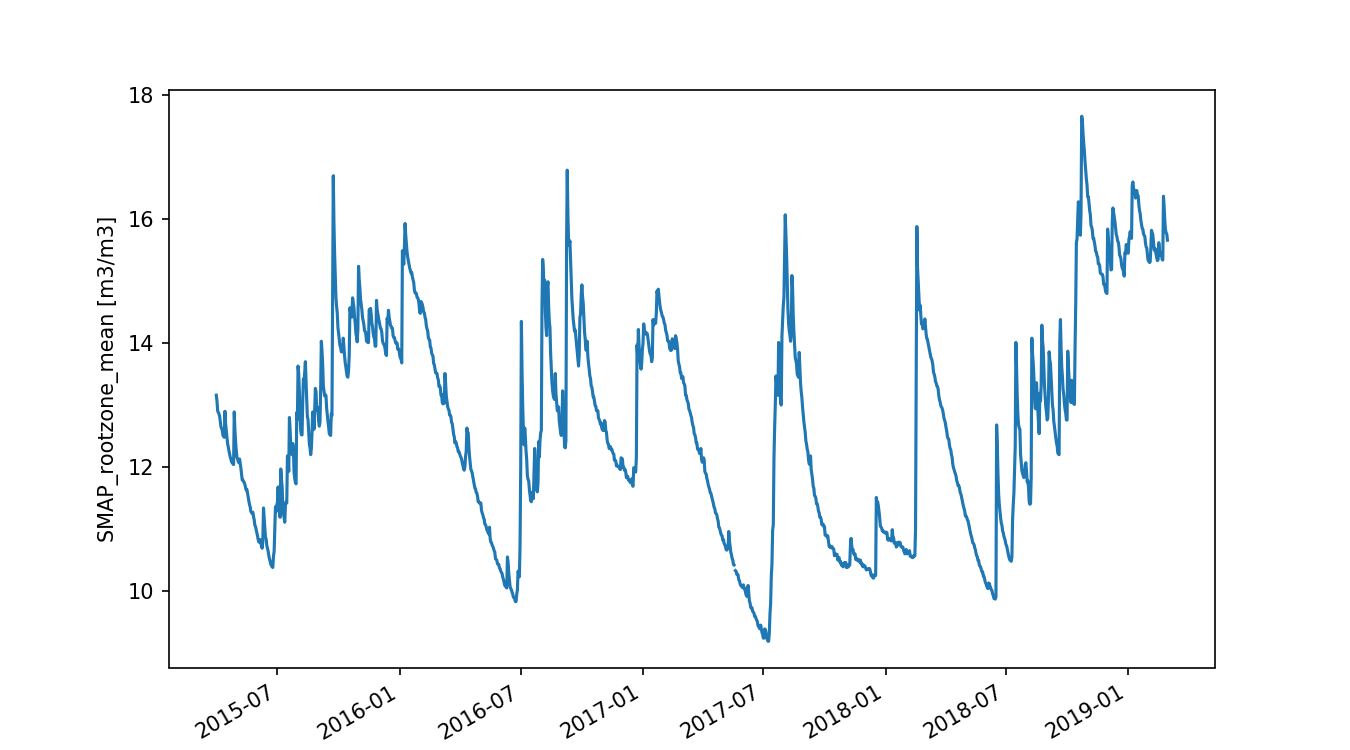

In [8]:
#%matplotlib inline
%matplotlib notebook
plt.rcParams['figure.figsize'] = [9, 5]

ds["SMAP_rootzone_mean"].plot()

The `xarray.Dataset` is easily saved to netCDF:

In [9]:
ds.to_netcdf("SMAP_rootzone-example.nc")  # save to a netcdf
r, df, c, ds = None, None, None, None     # remove

For the app we will need to concatenate a list of `xarray.Dataset`s like the one above, then merge with the other datasets from the SMV so that all of the data for an array of sample points can be indexed along common axes. This function will merge all of the SMV datasets for a series of sample points:

In [10]:
def xrdataset(samples, datasets):
    """ """
    
    bydataset = []                                  # xr dataset for each dataset
    for d in datasets:                              # loop over dataset names
        xrds = [s.xr[d] for s in samples.values()]  # get dataset for all samples
        bydataset.append(xr.concat(xrds, "sample")) # concat all along sample dim
    
    return(xr.merge(bydataset))                     # merge all concat'd datasets

## EASE Grid

Spatial queries to the Soil Moisture Visualizer return data corresponding to 9- by 9-km cells within the EASE grid system. Read about the EASE grid at the NSIDC's web page: https://nsidc.org/data/ease

The next two cells show how to select arrays of EASE grid sample points that fall within an input polygon so that they can be used to submit a series of data requests to the SMV. We will combine everything into one more function (**get_ease**) to use later in our batch processing routine.
      
**Two binary files contain the arrays corresponding to global EASE grid centroid latitudes and longitudes, respectively. Open the two files and read into `numpy` arrays:**

In [11]:
lats = "docs/EASE2_M09km.lats.3856x1624x1.double"
lons = "docs/EASE2_M09km.lons.3856x1624x1.double"

lat_array = np.fromfile(lats, dtype=np.float64).flatten() # read lat to np.array
lon_array = np.fromfile(lons, dtype=np.float64).flatten() # read lon to np.array

c = np.dstack((lon_array, lat_array))[0]                  # zip lat, lon
c

array([[-179.9533195 ,   84.6564188 ],
       [-179.85995851,   84.6564188 ],
       [-179.76659751,   84.6564188 ],
       ...,
       [ 179.76659751,  -84.6564188 ],
       [ 179.85995851,  -84.6564188 ],
       [ 179.9533195 ,  -84.6564188 ]])

**Select a 2-dimensional array of EASE grid centroids using some arbitrary latitude, longitude bounds:** 

In [12]:
selection = c[(-90<lon_array) & (lon_array<-85) & (25<lat_array) & (lat_array<30)]
selection

array([[-89.9533195 ,  29.94568162],
       [-89.85995851,  29.94568162],
       [-89.76659751,  29.94568162],
       ...,
       [-85.19190871,  25.02339698],
       [-85.09854772,  25.02339698],
       [-85.00518672,  25.02339698]])

## get_ease(geom): return a sample of EASE grid points for an input polygon geometry
uses the logic above to select an array of coordinates within bounding extent of the polygon

In [13]:
def get_ease(geom):
    
    # geom.bounds method returns a tuple of bounding coordinates:
    sel_minlon, sel_minlat, sel_maxlon, sel_maxlat = geom.bounds
    
    # index the xy array with bool conditions based on extent
    sel_ease = c[(sel_minlon<lon_array) & (lon_array<sel_maxlon) & 
                 (sel_minlat<lat_array) & (lat_array<sel_maxlat)]
    
    # further reduce to pts contained within the selected geometry
    sel_ease_poly = [pt for pt in sel_ease if geom.contains(
        shape({"coordinates": [pt[0], pt[1]], "type": "Point"}))]
    
    return(sel_ease_poly)

Now we need to take care of one final step before building the UI logic.

## Reading an USFS data from GeoJSON

The original dataset was a shapefile, but we reprojected and saved as GeoJSON using *ogr2ogr* from the GDAL/OGR binaries package available at OSGeo.

Let's open the GeoJSON and reorganize it as a pandas data frame. Read to a dictionary with `json.load` and print the first feature:

In [14]:
with open("sites/Sites_lf_geo.json", "r") as f:
    shapes = json.load(f)

shapes["features"][0]

{'type': 'Feature',
 'properties': {'OBJECTID': 61,
  'RANGERDIST': '99030501010343',
  'REGION': '03',
  'FORESTNUMB': '05',
  'DISTRICTNU': '01',
  'DISTRICTOR': '030501',
  'FORESTNAME': 'Coronado National Forest',
  'DISTRICTNA': 'Douglas Ranger District',
  'GIS_ACRES': 434025.2,
  'SHAPE_Leng': 3.96360236158,
  'SHAPE_Area': 0.16722952205,
  'Rowid_': 59,
  'FID_1': 60,
  'COUNT': 8159,
  'AREA': 509937500.0,
  'MIN': -79,
  'MAX': 34,
  'RANGE': 113,
  'MEAN': -42.6505699228,
  'STD': 15.107567792,
  'SUM': -347986.0,
  'VARIETY': 96,
  'MAJORITY': -51,
  'MINORITY': -79,
  'MEDIAN': -44,
  'Count_1': 8270.0,
  'Count_2': 8269.0,
  'Count_3': 8270.0,
  'Count_4': 8271.0,
  'Count_5': 8269.0,
  'Count_6': 8257.0,
  'Count_7': 8266.0,
  'Count_8': 8273.0,
  'Count_9': 8272.0,
  'Count_10': 8274.0,
  'Count_11': 8253.0,
  'Count_12': 8256.0,
  'Count_13': 8263.0,
  'Count_14': 8268.0,
  'Count_15': 8262.0,
  'Count_16': 8234.0,
  'Count_17': 8263.0,
  'Count_18': 8268.0,
  'Count_1

Now we need to add a style attribute to each feature so they have unique color schemes on the map widget. 

**1. Steps to generate the color scheme:**
* use `numpy.linspace` to generate an array of evenly space values between 0-1 
* vectorize `matplotlib.cm` *Set3* colormap against the array
* convert to hexadecimal colors with `matplotlib.colors.rgb2hex`

**2. Iterate over features, adding "id" and "style" to feature properties and collecting some helpful spatial information:** polygon feature, centroid, EASE grid points contained within, color, and some empty slots for later.

**3. Return all as a `pandas.DataFrame`.

We'll wrap this whole routine up in a function to allow future users to use any input GeoJSON file in the app:

In [15]:
def get_colors(n):
    """ """
    
    ncols = np.linspace(0.0, 1.0, n)                        # get evenly-spaced rgb 
    cols = [colors.rgb2hex(d[0:3]) for d in cm.Set3(ncols)] # return hexadecimal colors
    return(cols)
    

def add_props(feat, i, col):
    """ """
    
    feat["properties"]["id"] = i         # add id to the feature's properties 
    feat["properties"]["style"] = {      # add dictionary with style attributes
        "color": col, 
        "fillColor": col, 
        "weight": 1, 
        "fillOpacity": 0.5}
    return(feat)


def get_spatialdf(geojson_file):
    """ """
    
    with open(geojson_file, "r") as f:              # open geojson for USFS sites
        
        shapes = json.load(f)                       # load to python dictionary
        features = shapes["features"]
        n = len(features)                           # count of features
        cols = get_colors(n)                        # get array of colors
        
        df = {"id": [],                             # a temp container to store
              "feature": [],                        #   the data for the output
              "centroid": [],                       #   data frame
              "ease_pts":[],
              "color": [],
              "poly": [],
              "data": []}

        for i, feat in enumerate(features):         # loop over features

            feat = add_props(feat, i, cols[i])      # add id and style props
            geom = feat["geometry"]                 # get the site's geometry
            shp = shape(geom)                       # make a shapely geometry object
            
            df["id"].append(i)                      # add id to dict
            df["feature"].append(feat)              # add updated feature to dict
            df["centroid"].append(shp.centroid)     # get the centroid of the site
            df["ease_pts"].append(get_ease(shp))    # get contained ease grid points
            df["poly"].append(mwg.GeoJSON(          # make poly layer
                data=feat,                          # GeoJSON feature as dict
                hover_style={
                    "color": "white",               # show white on hover
                    "fillOpacity": 0.8}))           # increase opac on hover
            df["color"].append(cols[i])             # add color to dict
            df["data"].append(None)                 # add place for data to dict

        return(pd.DataFrame(df))


get_spatialdf("sites/Sites_lf_geo.json")

,id,feature,centroid,ease_pts,color,poly,data
0,0,"{'type': 'Feature', 'properties': {'OBJECTID':...",POINT (-109.3275890439514 31.77473409909402),"[[-109.37240663900413, 32.0802909170736], [-10...",#8dd3c7,"GeoJSON(data={'type': 'Feature', 'properties':...",None
1,1,"{'type': 'Feature', 'properties': {'OBJECTID':...",POINT (-110.5369671997131 31.50507306651894),"[[-110.39937759336097, 31.83155788300685], [-1...",#ffffb3,"GeoJSON(data={'type': 'Feature', 'properties':...",None
2,2,"{'type': 'Feature', 'properties': {'OBJECTID':...",POINT (-108.5668103027782 33.65380769018405),"[[-108.71887966804978, 33.84064093649531], [-1...",#bebada,"GeoJSON(data={'type': 'Feature', 'properties':...",None
3,3,"{'type': 'Feature', 'properties': {'OBJECTID':...",POINT (-111.6416464046803 35.29808929946645),"[[-111.79979253112033, 35.55089786936417], [-1...",#80b1d3,"GeoJSON(data={'type': 'Feature', 'properties':...",None
4,4,"{'type': 'Feature', 'properties': {'OBJECTID':...",POINT (-108.6731791358784 33.99668527552035),"[[-108.62551867219916, 34.17994513807948], [-1...",#fdb462,"GeoJSON(data={'type': 'Feature', 'properties':...",None
5,5,"{'type': 'Feature', 'properties': {'OBJECTID':...",POINT (-109.4019421294809 34.02016517347109),"[[-109.65248962655602, 34.17994513807948], [-1...",#b3de69,"GeoJSON(data={'type': 'Feature', 'properties':...",None
6,6,"{'type': 'Feature', 'properties': {'OBJECTID':...",POINT (-103.5170675943372 47.60668114935555),"[[-103.02385892116182, 48.10468383318226], [-1...",#d9d9d9,"GeoJSON(data={'type': 'Feature', 'properties':...",None
7,7,"{'type': 'Feature', 'properties': {'OBJECTID':...",POINT (-103.5564102657701 46.75216648118248),"[[-103.58402489626556, 47.271658915165574], [-...",#bc80bd,"GeoJSON(data={'type': 'Feature', 'properties':...",None
8,8,"{'type': 'Feature', 'properties': {'OBJECTID':...",POINT (-106.8638924058635 37.71468774390969),"[[-107.22510373443983, 37.91860118949151], [-1...",#ccebc5,"GeoJSON(data={'type': 'Feature', 'properties':...",None
9,9,"{'type': 'Feature', 'properties': {'OBJECTID':...",POINT (-103.0768881657713 37.33786865184727),"[[-103.86410788381743, 37.829598951649224], [-...",#ffed6f,"GeoJSON(data={'type': 'Feature', 'properties':...",None


-----------------------------------------
# Building a UI in Jupyter with `ipywidgets` and `ipyleaflet`
The next couple cells are pretty long, but they provide some nice functionality for interactive query and display of the SMV data. The cell below initializes the widgets that we'll draw in the cells to come:

1. Make `ipyleaflet` map widget
2. Make map layer of USFS sites from the `geopandas` data frame created above
3. Make a submit button to begin sending series of requests to the SMV
4. Make progress bar to monitor progress of the requests

In [16]:
map_widget = mwg.Map(
    layers=(mwg.basemap_to_tiles(mwg.basemaps.Esri.WorldImagery),), # basemap
    center=(33, -109),                                              # map center
    zoom=7,                                                         # zoom level
    scroll_wheel_zoom=True)                                         # scrollable
    
submit_button = wg.Button( 
    description='Submit', 
    disabled=True, 
    button_style='success')

progress_bar = wg.IntProgress(
    description="Progress: ", 
    layout=wg.Layout(width="95%"))

# ---------------------------------------------------------------------------------
# checkbox groups

smvds2 = smvds.drop(["FLUXNET_surface","FLUXNET_rootzone"])         # FLUXNET is broken???
grps = ["source", "units", "native_res","type", "soil_zone"]

def chkbx(d):
    c = wg.Checkbox(
        value=True, 
        indent=False, 
        description=str(d), 
        disabled=True, 
        layout=wg.Layout(
            width='auto', 
            overflow_y="hidden"))
    return(c)

lbl = lambda d: [wg.HTML("<b>"+d+"</b>")]
chkbx_grps = {d: list(map(chkbx, smvds2[d].unique())) for d in grps}
chkbx_ui = wg.HBox(
    children=[wg.VBox(lbl(n)+g) for n,g in chkbx_grps.items()], 
    layout=wg.Layout(border='1px solid lightgray', width="45%"))

# ---------------------------------------------------------------------------------

ui = wg.VBox([
    map_widget, 
    wg.HBox([submit_button, progress_bar]),
    chkbx_ui])

---------------------------------
## A class to manage the map marker and data for one `SMVSample`

Each request to the SMV is treated as one object within the namespace of the map and plot UI. This class object contains all of the attributes required to describe the ...

In [17]:
class SMVSample(object):

    def __init__(self, id, lat, lon):
        self.i = id                        # most of this self-explanatory ->
        self.lat = lat
        self.lon = lon
        self.pt = mwg.CircleMarker(
            location=(self.lat, self.lon),
            radius=7,                                         # in pixels
            stroke=False,                           
            fill_opacity=0.6,
            fill_color="black")                           
        self.fn = f"sample_{self.i}-{self.lat}-{self.lon}."   # out filenames
        self.rurl = url+f"lt={self.lat}&ln={self.lon}&d=smap" # request url

    def update_pt(self, **kwargs):
        for arg, val in kwargs.items():
            setattr(self.pt, arg, val)
        
    def toggle_pt(self, event, type, coordinates):
        """ """
        if self.on:
            self.on = False
            self.update_pt(opacity=0.1)
        else:
            self.on = True
            self.update_pt(opacity=0.6)           
        
    def submit(self):
        """ """
        self.response = requests.get(self.rurl, cookies=auth)   # submit SMV request
        self.df = get_pandas(self.response.text)                # read to pandas df
        self.dims = get_sample(self.i, lat=self.lat, lon=self.lon) # get arrays for dims
        self.xr = {c: get_xr(self.df[c], self.dims) for c in list(self.df)} # get xarray 
        self.counts = {c: "Placeholder" for c in list(self.df)} # get count of valid  
        self.on = True                                          # set sample status on
        self.pt.on_click(self.toggle_pt)                        # set callback

    def save_csv(self, fn=None):
        """ """
        filename = fn if fn else "_".join(self.fn)+".csv"       # filename components
        self.df.to_csv(filename)                                # save pandas df to csv

Test instantiation of `SMVSample` class:

In [18]:
sample = SMVSample(0, 30, -90)
sample

And the request to SMV is triggered by calling `download`:

In [19]:
sample.submit()              # send request to SMV and process the download
sample.xr['SMAP_rootzone']   # display the SMAP_rootzone dataset

<xarray.Dataset>
Dimensions:             (sample: 1, time: 1428)
Coordinates:
  * sample              (sample) int32 0
  * time                (time) datetime64[ns] 2015-03-31 ... 2019-02-25
Data variables:
    SMAP_rootzone_mean  (time) float64 25.78 25.7 25.6 ... 27.57 27.78 27.64
    SMAP_rootzone_min   (time) float64 25.87 25.77 25.69 ... 27.63 28.28 27.83
    SMAP_rootzone_max   (time) float64 25.92 25.8 25.74 ... 27.66 28.59 27.99
    sample_name         (sample) <U8 'sample00'
    lat                 (sample) float64 30.0
    lon                 (sample) float64 -90.0
Attributes:
    source:         SMAP
    type:           spaceborne
    units:          m3/m3
    description:    Mean vol (%) soil moisture at 0-100cm 
    soil_zone:      rootzone
    soil_depth:     0-5, 0-100 cm
    native_res:     9000-m 
    time_coverage:  2015-present
    dataset:        SMAP_rootzone
    featureType:    timeSeries

A class to handle plotting after interactions with the UI:

In [20]:
%matplotlib notebook

def exnan(variable):
    return(np.isnan(np.nanmean(variable)))

def filt(data, dim=None, var=None, att=None):
    if dim: data = data.isel(**dim)             # if sample, filter with isel()
    if var: data = data[var]                    # if variables, select   
    if att: data = data.filter_by_attrs(**att)  # if attributes, filter with filter_by_attrs()
    return(data)

def flat(variable):
    """ """
    if len(variable.dims)>1:
        return(variable.mean(dim="sample"))
    else:
        return(variable)

# ---------------------------------------------------------------------------------


class Plotting(object):
    
    def __init__(self, xr, chkbx, samples):
        self.xr = xr
        self.chk = chkbx
        self.samp = samples
        
        self.smv = [v for v in list(self.xr) if "source" in self.xr[v].attrs]
        
        self.chkbools = {} # add updater callback to all checkboxes; build bools table
        for group in self.chk:
            self.chkbools[group] = {}
            for dataset in self.chk[group]:
                dataset.observe(self.att_updater, names='value')
                desc = dataset.description
                self.chkbools[group][desc] = dataset.value
                
        self.sampbools = [] # add updater callback for pt clicks
        for i, sample in self.samp.items():
            self.sampbools.append((i, sample.lat, sample.lon, sample.on))
            sample.pt.on_click(self.samp_updater)
        self.sampbools = pd.DataFrame(self.sampbools, columns=["id","y", "x","on"])
        self.sampbools = self.sampbools.set_index("id")


    def samp_updater(self, event, type, coordinates):
        """ """
        id = self.sampbools.loc[
            (self.sampbools["y"]==coordinates[0]) & 
            (self.sampbools["x"]==coordinates[1])]
        if self.sampbools[id]["on"]:
            self.sampbools.at[id, "on"] = False
        else:
            self.sampbools.at[id, "on"] = True
            
        t = []
        for i, row in self.sampbools.iterrows():
            if row["on"]:
                t.append(i)
        self.dimsbool = dict(sample=t)
        self.plot()
        

    def att_updater(self, change):

        # update bools table     --->>> attributes
        attribute_filter=dict()
        desc = change.owner.description
        for g in self.chkbools:
            for d in self.chkbools[g]:
                if d==desc:
                    self.chkbools[g][d] = change.new
        #source = [a for a,v in self.chkbools["source"] if not v]
        #units = [a for a,v in self.chkbools["units"] if not v]
        #native_res = [a for a,v in self.chkbools["native_res"] if not v]
        #type = [a for a,v in self.chkbools["type"] if not v]
        #soil_zone = [a for a,v in self.chkbools["soil_zone"] if not v] <<<---

         
    def plot(self, dim=None, var=None, att=None):
        """ """
        
        dim = self.dimsbool if dim is None else dim
        
        data = filt(self.xr, dim=dim, var=var, att=att)
        for v in data:
            variable = data[v]
            print(variable)
            #variable = flat()
            if not exnan(variable.data):
                variable.plot()

### Class to manage requests for most recently selected site
**button_click_handler** reacts to user clicking the submit button by iterating over the sample EASE points resulting from the **layer_click_handler** above and sends the download requests to the SMV and converts text to xarray:

In [21]:
class App(object):
    
    def __init__(self, geojson, ui, widgets):
        self.ui = ui
        self.map =widgets[0]                        # map widget
        self.submit = widgets[1]                    # submit button
        self.pbar = widgets[2]                      # progress bar
        self.chkbx = widgets[3]                     # plot checkboxes

        self.points = mwg.LayerGroup()              # make empty container for samples
        self.map.add_layer(self.points)             # and add to map widget
        self.submit.on_click(self.submit_handler)   # set submit bttn callback
        
        self.df = get_spatialdf(geojson)# make spatial df summarizing features
        
        for ix, row in self.df.iterrows():          # loop over rows
            poly = row["poly"]                      # get layer poly
            poly.on_click(self.lyr_click_handler)   # set callback
            self.map.add_layer(poly)                # add to map

        # get other metadata about datasets and SMV in general; FLUXNET breaks???
        self.datasets = [d for d in smvds.index.tolist() if "FLUXNET" not in d]

    def lyr_click_handler(self, **kwargs): 
        """Routine for when a new USFS polygon is selected."""
        if list(kwargs.keys()) != ['event', 'properties']: # check event; skip bmap
             return(None)

        self.id = int(kwargs["properties"]["id"])          # set selected poly id
        row = self.df.iloc[self.id]                        # get row for selected
        cent = row["centroid"]                             # get centroid
        
        self.map.center = (cent.y, cent.x)                 # center map
        self.map.zoom = 9                                  # zoom map

        if not row["data"]:                                # if first select;
            ease = row["ease_pts"]                         #  make SMVSample obj
            self.data = {}                                 #  for each sample pt
            for i, c in enumerate(ease):                   # loop over EASE pts
                self.data[i] = SMVSample(i, c[1], c[0])    #  add SMVSample to d
            self.df.at[self.id, "data"] = self.data        #  and data link to df
        else:                                              # else
            self.data = row["data"]                        #  load data from before
            
        self.submit.disabled = False                       # enable submit bttn
        self.points.clear_layers()                         # clear ease grid pts
        for sample in self.data.values():                  # loop and add to map 
            self.points.add_layer(sample.pt)

    def submit_handler(self, b):
        """Resets UI and sends requests to SMV when new submit."""
        self.pbar.min = 0                                  # reset progress bar
        self.pbar.max = len(self.points.layers)            #
        self.pbar.value = 0                                #
        self.submit.disabled = True                        # disable submit button
        for sample in self.data.values():                  # loop over sample pts
            self.pbar.value += 1                           # update progress bar
            sample.update_pt(                              # update style
                stroke=True, color="white", opacity=0.6)   #
            sample.submit()                                # download the data

        self.xr = xrdataset(self.data, self.datasets)      # merge all data as xr
        for label, group in self.chkbx.items():            # enable plotting ui
            for box in group:
                box.disabled = False
    
    def plotter(self, dataset, clear=True):
        """ """
        on = [self.data.values()]
        #select = []

# Put it all the steps together; display the app
The classes above provide all of the functionality of the app. The three steps below 

Open the input GeoJSON and get data frame structure we created before.

In [22]:
appdata = App("sites/Sites_lf_geo.json", ui, (
    map_widget, submit_button, progress_bar, chkbx_grps))

# Display the UI

**Instructions:**
1. Run the following cell.          
2. Select a USFS polygon on the map; an array of EASE grid points will be displayed that represent the locations of the data available through the Soil Moisture Visualizer API.               
3. Click *Submit*; wait for the downloads to process.            
4. Explore the data interactively.            
    * Click a point to toggle the associated data on and off; this adds/removes the data for all visualizations.
    * Double click a point to disable all other points.

In [23]:
appdata.ui

## plotter class

In [22]:
p = Plotting(appdata.xr, chkbx_grps, appdata.data)

AttributeError: 'App' object has no attribute 'xr'

----------------------------------------------------------
```
#
#
#
#
#
#
#
#
```

In [ ]:
p.plot(
    dim=dict(sample=1),                            # not required; omit to average
    #var=["SMAP_surface_mean", "SMAP_surface_max"], # not required; list of vars
    att=dict(source="SMAP")
)

In [ ]:
p.chkbools

In [ ]:
def basic_filter(data, dim=None, var=None, att=None):
    if dim: data = data.isel(**dim)             # if sample, filter with isel()
    if var: data = data[var]                    # if variables, select   
    if att: data = data.filter_by_attrs(**att)
    return(data)

def basic_plot(data):
    smv = [v for v in list(data) if "source" in data[v].attrs] # get plottable vars
    for v in smv:
        nancheck = np.isnan(np.nanmean(data[v].data))
        if not nancheck:
            if len(data.dims)>1:
                data[v].mean(dim="sample").plot()
            else:
                data[v].plot()

In [ ]:
filtered = basic_filter(
    appdata.xr,                                    # the big xarray dataset
    dim=dict(sample=1),                            # not required; omit to average
    var=["SMAP_surface_mean", "SMAP_surface_max"], # not required; list of vars
    att=dict(source="SMAP"))                       # not required; filter by att:value pair

filtered

In [ ]:
%matplotlib notebook
basic_plot(filtered)

# STOP

In [ ]:

# ---------------------------------------------------------------------------------
smvds2 = smvds.drop(["FLUXNET_surface","FLUXNET_rootzone"])                     # FLUXNET is broken???
grps = ["source", "units", "native_res","type", "soil_zone"]

lyt = wg.Layout(width='auto', overflow_y="hidden")
chkbx = lambda a: wg.Checkbox(value=False, description=str(d), indent=False, disabled=True, layout=lyt)
lbl = lambda d: [wg.HTML("<b>"+d+"</b>")]

chkbx_grps = {d: list(map(chkbx, smvds2[d].unique())) for d in grps}
chkbx_ui = wg.HBox(
    children=[wg.VBox(lbl(n)+g) for n,g in chkbx_grps.items()], 
    layout=wg.Layout(border='1px solid lightgray', width="45%"))


def filt(self, data=None, dim=None, attr=None):      
    """
    Dims, attrs are both dictionaries. e.g.
      attrs: dict(soil_zone="surface", units="m3/m3")
      dims: dict(sample=0)
    """
    data = data if data else self.xr
    if dim:
        data = data.isel(**dim)                 # filter by dimensions dict
    if attr:
        data = data.filter_by_attrs(**attr)   # filter by attribute dict
    return(data)